In [4]:
from mpcrl import *
from WindGym import WindFarmEnv
from mpcrl import make_config
from typing import Any, Dict, Optional, Union
import gymnasium as gym
from py_wake.examples.data.hornsrev1 import V80
import numpy as np

In [5]:
class MPCenv(WindFarmEnv):
    """
    Wind Farm Environment with MPC controller.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        
        obs, info = super().reset(seed=seed, options=options)

        self.USE_VARIABLE_HORIZON = True   # Use variable prediction horizon (paper's approach)
        self.USE_TIME_SHIFTED = True      # Use time-shifted cost function (paper's best)
        self.APPLY_YAW_PENALTY = True      # Use Equation 5 penalty for large yaw angles

        self.mpc_model = WindFarmModel(self.x_pos, self.y_pos, D=self.D, 
                                       wt=self.turbine,
                                       cache_size=64000, 
                                       cache_quant=0.25, wind_quant=0.25,
                                       apply_yaw_penalty=self.APPLY_YAW_PENALTY)
        self.previous_opt_params = None
        return obs, info

    def step(self, action):

        # Step 1: update the MPC model with the current state
        estimated_wd = action[0]
        estimated_ws = action[1]
        estimated_TI = action[2]
        # TODO: Should we use _scaling_ or _inflow_, or maybe something else? 
        # The estimates are all from -1 to 1, we need to convert them back to the original range
        estimated_wd = (estimated_wd + 1) / 2 * (self.wd_scaling_max - self.wd_scaling_min) + self.wd_scaling_min
        estimated_ws = (estimated_ws + 1) / 2 * (self.ws_scaling_max - self.ws_scaling_min) + self.ws_scaling_min
        estimated_TI = (estimated_TI + 1) / 2 * (self.ti_scaling_max - self.ti_scaling_min) + self.ti_scaling_min

        self.mpc_model.update_conditions(U_inf=estimated_ws, TI=estimated_TI, wd=estimated_wd)
        
        current_yaws_orig = self.current_yaw.copy()
        current_yaws_sorted = current_yaws_orig[self.mpc_model.sorted_indices]   


        # Step 2: optimize the yaw angles
        optimized_params = optimize_farm_back2front(
            self.mpc_model, current_yaws_sorted, 
            r_gamma=0.3, # yaw rate (deg/s)
            t_AH=100.0,  # action horizon (s)
            dt_opt=10.0,  # optimization time step (s)
            T_opt=500.0,  # prediction horizon (s)
            maxfun=50,
            seed=42,
            initial_params=self.previous_opt_params
        )

        self.previous_opt_params = optimized_params.copy()


        dt_mpc = 60 # MPC control interval (s)
        t_action, trajectories, _ = run_farm_delay_loop_optimized(
            self.mpc_model, optimized_params, current_yaws_sorted, 
            r_gamma=0.3, t_AH=100.0, dt=dt_mpc, T=dt_mpc
        )

        next_yaws_sorted = np.array([traj[-1] for traj in trajectories])
        next_yaws_orig = next_yaws_sorted[self.mpc_model.unsorted_indices]

        # The action should then be:
        yaw_action = (next_yaws_orig - self.yaw_min) / (self.yaw_max - self.yaw_min) * 2 - 1

        # Do the env step:
        obs, reward, done, truncated, info = super().step(yaw_action) 

        if truncated:
            self.mpc_model.cache_clear()

        # Add the estimated conditions to the info dict
        info['estimated_wd'] = estimated_wd
        info['estimated_ws'] = estimated_ws
        info['estimated_TI'] = estimated_TI

        return obs, reward, done, truncated, info
    
    def _init_spaces(self):
        """
        This function initializes the observation and action spaces.
        This is done in a seperate function, so we can replace it in the multi agent version of the environment
        """
        self.observation_space = gym.spaces.Box(
            low=-1.0, high=1.0, shape=((self.obs_var),), dtype=np.float32
        )
        self.action_space = gym.spaces.Box(
            low=-1, high=1, shape=((3),), dtype=np.float32
        )    
    

In [6]:
env = MPCenv(config=make_config(),
                turbine=V80(),  # e.g., IEA37/DTU10MW WT from PyWake
                x_pos=np.array([0, 400, 800]),  # x positions of the turbines
                y_pos=np.array([0, 0, 0]),      # y positions of the turbines
                ws_scaling_min=5, ws_scaling_max=15,  # wind speed scaling
                wd_scaling_min=250, wd_scaling_max=290,  # wind direction scaling
                TI_scaling_min=0.00, TI_scaling_max=0.15,  # turbulence intensity scaling
                turbtype="None",
                dt_env=60,
                dt_sim=10,
                yaw_step_sim=10*0.3,  # 10 sim step * 0.3 (yaw actuation time)
                yaw_init='Zeros',
                )

Steady state steps: 6.0


In [7]:
obs, info = env.reset()

Steady state steps: 7.0


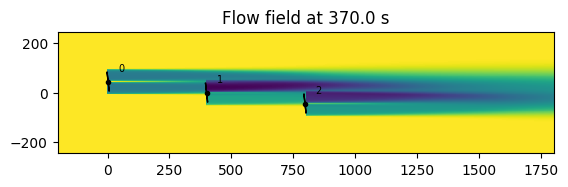

In [8]:
env.plot_farm()

In [9]:
obs, reward, terminated, truncated,  info = env.step(env.action_space.sample())

In [10]:
info["estimated_TI"], info["estimated_ws"], info["estimated_wd"]

(np.float32(0.3931676), np.float32(6.561784), np.float32(251.72142))

In [11]:
env.dt_sim

10